In [ ]:
%%shell
pip install gdown
gdown https://drive.google.com/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7
mkdir dataset
unzip /content/speech-emotion-recognition-ravdess-data.zip -d dataset


Downloading...
From: https://drive.google.com/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7
To: /content/speech-emotion-recognition-ravdess-data.zip
78.1MB [00:01, 41.8MB/s]
Archive:  /content/speech-emotion-recognition-ravdess-data.zip
   creating: dataset/Actor_01/
  inflating: dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: dataset/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: dataset/Actor_01/03-01-03-01-01-01-01.wav

In [ ]:
import glob  
import os  
import librosa  
import numpy as np  
from keras.models import Sequential  
from keras.layers import Dense, Activation  
from keras.layers import Dropout  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt

def extract_feature(file_name): 
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz



In [ ]:
def parse_audiofile():
  
  features,labels = np.empty((0,193)),np.empty(0)
  for actors in (os.listdir('/content/dataset')):
    counter = 0  
    for item in os.listdir('/content/dataset/' + actors):
      emotion = os.path.basename(item).split("-")[2]
      file_name = '/content/dataset/{}/{}'.format(actors,item)
      try:
        mfccs,chroma,mel,contrast,tonnetz = extract_feature(file_name)
      except Exception as e:
        print('Error encountered while parsing file: ',fn)
        continue
      ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
      features = np.vstack([features,ext_features])
      labels = np.append(labels,emotion)
      

  return np.array(features),np.array(labels,dtype = np.int)

features,labels = parse_audiofile()

    

In [ ]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels+1))
    one_hot_encode[np.arange(n_labels), labels] = 1
    one_hot_encode=np.delete(one_hot_encode, 0, axis=1)
    return one_hot_encode

latest_labels = one_hot_encode(labels)
np.save('X',features)
np.save('y',latest_labels)


In [ ]:
X = np.load('X.npy')
y = np.load('y.npy')
print(len(X))
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)


1440


In [ ]:
n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = n_dim*4 # approx n_dim * 2
n_hidden_units_3 = n_dim*2 # half of layer 2
# n_hidden_units_4 = 100
print('n_dim', n_dim)
print(n_classes)
print(train_x.shape[0])

def create_model(activation_function='relu', init_type='normal', optimiser='adam', dropout_rate=0.2):
    model = Sequential()
    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, init=init_type, activation=activation_function))
    # layer 2
    model.add(Dense(n_hidden_units_2, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    #layer4
    # model.add(Dense(n_hidden_units_4, init=init_type, activation=activation_function))
    # model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, init=init_type, activation='softmax'))
    #model compilation
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

model = create_model()
model.summary()

n_dim 193
8
964
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 193)               37442     
_________________________________________________________________
dense_101 (Dense)            (None, 772)               149768    
_________________________________________________________________
dropout_56 (Dropout)         (None, 772)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 386)               298378    
_________________________________________________________________
dropout_57 (Dropout)         (None, 386)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 8)                 3096      
Total params: 488,684
Trainable params: 488,684
Non-trainable params: 0
_______________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, input_dim=193, activation="relu", kernel_initializer="normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(772, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(386, activation="relu", kernel_initializer="normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="softmax", kernel_initializer="normal")`


In [ ]:
history = model.fit(train_x,train_y,epochs=500,batch_size =119,  validation_data=(test_x, test_y))

Train on 964 samples, validate on 476 samples
Epoch 1/500
964/964 [==============================] - 0s 200us/step - loss: 0.0048 - accuracy: 0.9979 - val_loss: 2.8706 - val_accuracy: 0.6996
Epoch 2/500
964/964 [==============================] - 0s 177us/step - loss: 0.0042 - accuracy: 0.9979 - val_loss: 2.8007 - val_accuracy: 0.6891
Epoch 3/500
964/964 [==============================] - 0s 177us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.7795 - val_accuracy: 0.6933
Epoch 4/500
964/964 [==============================] - 0s 181us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.7737 - val_accuracy: 0.6912
Epoch 5/500
964/964 [==============================] - 0s 185us/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 2.7606 - val_accuracy: 0.6849
Epoch 6/500
964/964 [==============================] - 0s 184us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.7650 - val_accuracy: 0.6870
Epoch 7/500
964/964 [==============================] - 0s 185us/step - loss: 0.0017 

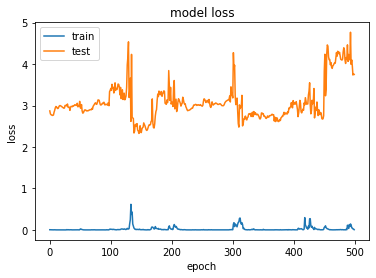

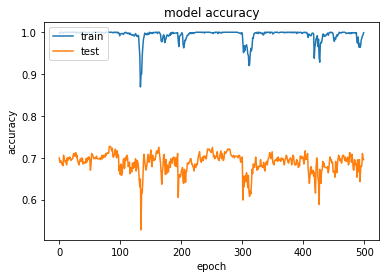

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

predict = model.predict(test_x,batch_size = 119)
y_pred =np.argmax(predict,1)
actual_y = np.argmax(test_y,1)

accuracy = accuracy_score(y_true=actual_y,y_pred=y_pred)
print(accuracy*100)

69.53781512605042


              precision    recall  f1-score   support

           0       0.66      0.59      0.62        32
           1       0.77      0.82      0.79        60
           2       0.70      0.69      0.69        51
           3       0.64      0.64      0.64        76
           4       0.78      0.73      0.76        70
           5       0.69      0.67      0.68        72
           6       0.64      0.64      0.64        55
           7       0.68      0.75      0.71        60

    accuracy                           0.70       476
   macro avg       0.69      0.69      0.69       476
weighted avg       0.70      0.70      0.69       476



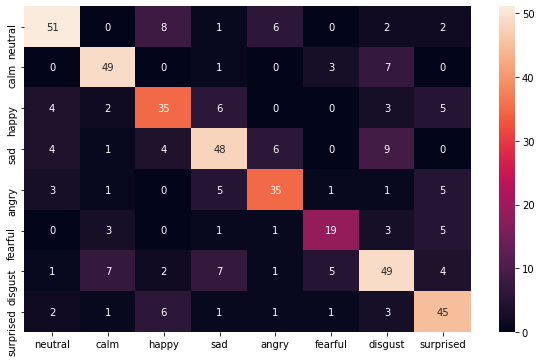

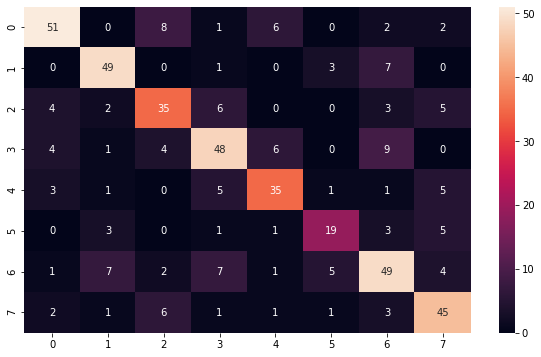

In [ ]:
predict_y_conf = []
actual_y_conf = []
emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
calm = 0
for i in range(0,test_y.shape[0]):
  actual_emo = emotions[actual_y[i]]
  predicted_emo = emotions[y_pred[i]]
  actual_y_conf.append(actual_emo)
  predict_y_conf.append(predicted_emo)


import sklearn.metrics as mt

cm = confusion_matrix(actual_y_conf,predict_y_conf)
print(mt.classification_report(actual_y,y_pred))
index = emotions
columns = emotions
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True) 

plt.figure(figsize=(10,6))  
sns.heatmap(cm, annot=True) 


[[1.0648421e-12 5.7244999e-12 2.3401890e-08 ... 9.9997592e-01
  5.3713306e-06 4.9589366e-15]
 [2.5978325e-06 3.5793682e-06 6.2422529e-05 ... 1.4323349e-01
  8.5608059e-01 4.9537420e-04]
 [9.6046638e-01 1.8857602e-02 6.3860512e-05 ... 7.7653704e-06
  6.8343896e-04 2.1362235e-05]
 ...
 [1.7396582e-08 5.7618297e-09 5.3753300e-09 ... 7.6973532e-07
  9.5160963e-04 1.4214309e-12]
 [8.1904865e-08 7.1642990e-11 1.5425483e-06 ... 4.6716897e-07
  9.1812632e-07 9.9999571e-01]
 [6.1258391e-02 9.0984333e-01 3.8041329e-05 ... 5.6643103e-07
  3.8678627e-05 1.0925758e-05]]
